# BrainIAK setup

Utilizing the tutorial codebase from [BrainIAK](https://brainiak.org/tutorials/).

In [114]:
!pip install deepdish ipython matplotlib nilearn notebook pandas seaborn watchdog
!pip install pip\<10
!pip install -U git+https://github.com/brainiak/brainiak
!git clone https://github.com/brainiak/brainiak-tutorials.git
!cd brainiak-tutorials/tutorials/; cp -r 07-searchlight 09-fcma 13-real-time utils.py setup_environment.sh /content/
!mkdir /root/brainiak_datasets

n
n
N



y
  Cloning https://github.com/brainiak/brainiak to /tmp/pip-lec34t1i-build
Requirement already up-to-date: cython in /usr/local/lib/python3.9/dist-packages (from brainiak==0.12.dev5+gee09359)
  Using cached https://files.pythonhosted.org/packages/bc/f2/749af7fd0e7703ddca6cea525ab40f26c3ca6cbe6c23658441c6f9705860/mpi4py-3.1.4.tar.gz
  Using cached https://files.pythonhosted.org/packages/22/7e/62b14c3bec4c87b0810accbee581b8ae2ef0715ec64883eeb3786d47f773/nitime-0.9.tar.gz
  Using cached https://files.pythonhosted.org/packages/89/62/189b502767f70a310a010c397fcd52169fdf75f6876e52beb54e98f1ce93/numpy-1.19.5-cp39-cp39-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c9/fa/8e158d81e3602da1e7bafbd4987938bc003fe4b0f44d65681e7f8face95a/scikit-learn-1.2.2.tar.gz
  scikit-learn 1.2.2 does not provide the extra 'alldeps'
Requirement already up-to-date: scipy!=1.0.0 in /usr/local/lib/python3.9/dist-packages (from brainiak==0.12.dev5+gee09359)
Requirement already 

In [ ]:
!cd /root/brainiak_datasets; wget -q --show-progress --no-check-certificate -r 'https://drive.google.com/uc?export=download&confirm=Yqoe&id=14m-YY-N3mCjCdHGkeVlTS4uA7WJzbQS0' -O 'NinetySix.zip'
!cd /root/brainiak_datasets/; unzip NinetySix.zip

NinetySix.zip       100%[===================>] 146.49M  83.1MB/s    in 1.8s    
Archive:  NinetySix.zip
replace NinetySix/Stimuli/RDM_hIT_fig1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [115]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


# Processing fMRI data

Four human subjects: BE, KO, SN, TI

Four ROIs from IT cortext: lFFA, rFFA, lPPA, rPPA

fMRI data for these participants was stored as a matlab file. Helper functions developed by BrainIAK help us make the files compatible with Python.

- The ROI names are listed in `roinames`
- The category label indices for each condition are listed in `labels`.  
- The names of the categories are listed in `categories`. 
- The data for each ROI, in the order of roinames, is stored in `roi_data`. 
- The images are stored as numpy arrays in `images`. Out of the 96 images, there are only 92 which we have labels for.


Each row of `roi_data` represents a stimulus (as defined by labels) and each column represents a voxel (there are different number of voxels in different ROIs). The data have been preprocessed and each entry is stored in terms of t-values (the test statistic). No time information and no baseline signal to be used as reference.

Our six image categories are:
1. Artificial inanimate
2. Human body part
3. Human face
4. Natural inanimate
5. Nonhuman body part
6. Nonhuman face

IT brain regions:
- lFFA: 34 voxels
- rFFA: 70 voxels
- lPPA: 348 voxels
- rPPA: 273 voxels

## 1.1: Generate baseline image order.

In order to compare RDMs, we need to ensure that each cell in the matrix is responsive to the same stimuli. This is not straightforward, given that four of the images presented do not have labels, and the images were presented to each individual in a different order.

In order to do so, I'm going to designate a specific order for the images along both axes. The images will be sorted by category, going 3-2-6-5-4-1. I will sort the images presented to subject BE by this category, and rearrange all other subject's data to match this ordering.

In [116]:
# import helper functions
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [117]:
# load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

Text(0, 0.5, 'Category')

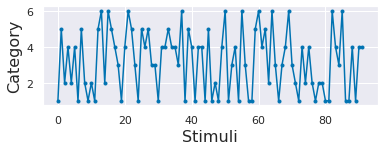

In [118]:
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.savefig

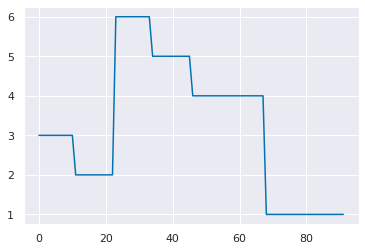

In [119]:
sort_ids = labels.argsort()

cat1_ids = list(sort_ids[0:24])
cat2_ids = list(sort_ids[24:36])
cat3_ids = list(sort_ids[36:47])
cat4_ids = list(sort_ids[47:69])
cat5_ids = list(sort_ids[69:81])
cat6_ids = list(sort_ids[81:92])

ordered_ids = cat3_ids + cat2_ids + cat6_ids + cat5_ids + cat4_ids + cat1_ids

ordered_images = images[ordered_ids]
ordered_labels = labels[ordered_ids]
ordered_categories = ['human face', 'human body part', 'nonhuman face', 'nonhuman body part', 'natural inanimate', 'artificial inanimate']
plt.plot(ordered_labels)

### 1.1.1: Inspect images

(-0.5, 174.5, 174.5, -0.5)

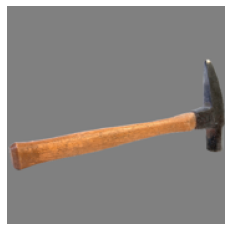

In [196]:
plt.imshow(images[0,0])
plt.grid(None)
plt.axis('off')

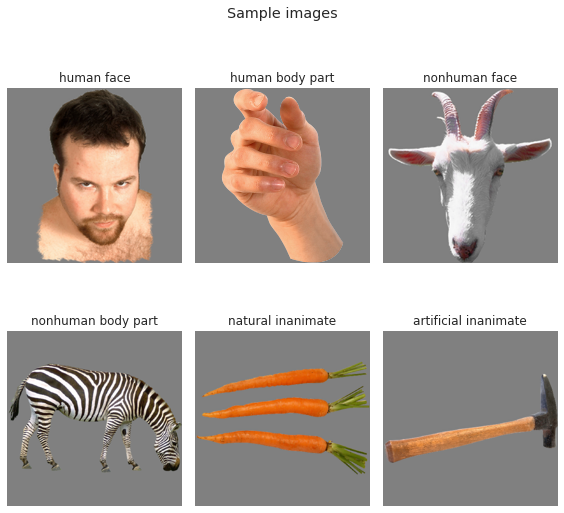

In [202]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,8))

counter = 0
image_ids = [cat3_ids[0], cat2_ids[0], cat6_ids[0], cat5_ids[0], cat4_ids[0], cat1_ids[0]]
for ax in axes.flat:
  im = ax.imshow(images[image_ids[counter], 0])
  ax.set_title(ordered_categories[counter])
  ax.grid(None)
  ax.axis('off')
  counter += 1

fig.suptitle('Sample images')
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

## 1.2: Example.

### 1.2.1: Load in and adjust the data.

In [ ]:
# Load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

In [ ]:
# adjust image ordering
current_ordering = []

for i in range(92):
  for j in range(96):
    if np.array_equal(ordered_images[i, 0], images[j, 0]):
      current_ordering.append(j)
  
current_ids = np.asarray(current_ordering)

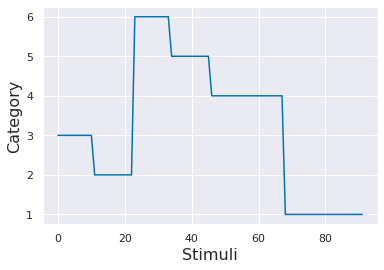

In [ ]:
plt.plot(labels[current_ids])
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

### 1.2.2: Generate the RSM.

(0.0, 92.0)

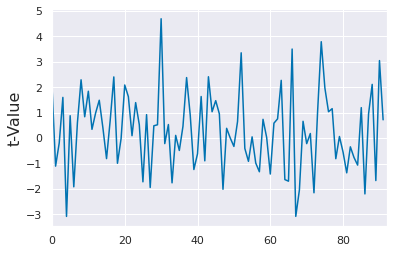

In [ ]:
# choose ROI index
roi_id = 0

sorted_roi_data = roi_data[roi_id][current_ids, :]
plt.plot(sorted_roi_data[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 92)

In [ ]:
label_locs = [11/2, 11 + 12/2, 23 + 11/2, 34 + 12/2, 46 + 22/2, 66 + 24/2]

Text(0.5, 1.0, 'RSM, sorted, lFFA')

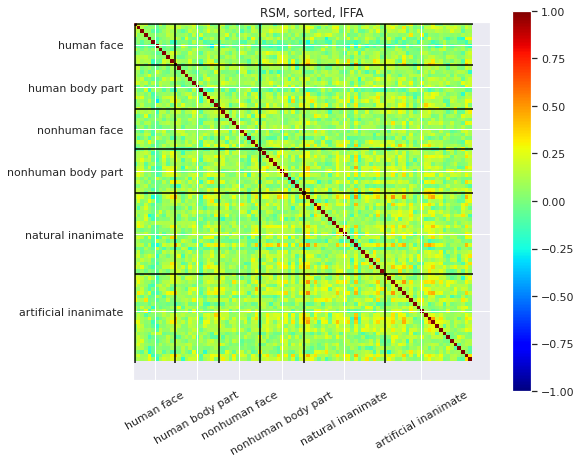

In [ ]:
# generate RSM
# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

rsm = np.corrcoef(sorted_roi_data)

plt.imshow(
    rsm, 
    cmap='jet', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(label_locs)
ax.set_xticklabels(ordered_categories, rotation = 30)
ax.set_yticks(label_locs - 4)
ax.set_yticklabels(ordered_categories)
ax.vlines(edges,0,92, color='black')
ax.hlines(edges,0,92, color='black')
ax.set_title('RSM, sorted, %s' % roi_names[roi_id])

### 1.2.3: Generate RDMs

Text(0.5, 1.0, 'RDM, sorted, lFFA')

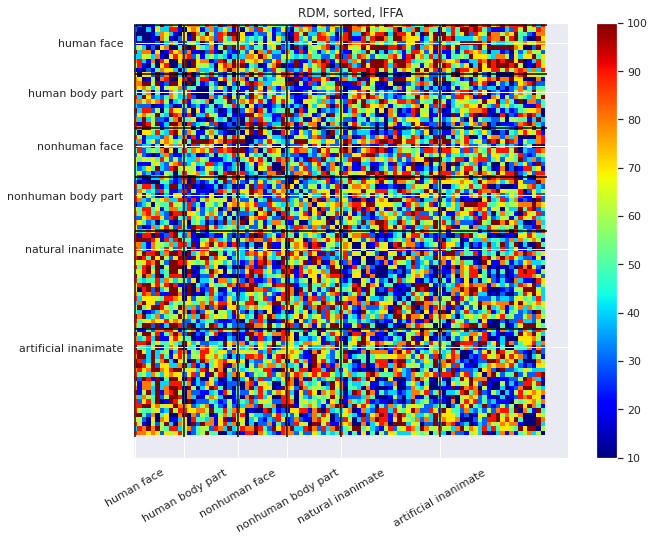

In [ ]:
# plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))

rdm = digitize_rdm(1-rsm, n_bins=10)

plt.imshow(
    rdm, 
    cmap='jet', 
)
plt.colorbar()

binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)))
ax.set_xticklabels(ordered_categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+4))
ax.set_yticklabels(ordered_categories)
ax.vlines(edges,0,92, color='black')
ax.hlines(edges,0,92, color='black')
ax.set_title('RDM, sorted, %s' % roi_names[roi_id])

## 1.3: Function to generate all RSMs and RDMs for a subject.

In [155]:
def generate_matrices(subj_initials):
  # outputs
  rsms = []
  rdms = []

  # load data
  data_pack = load_data_for_a_subj(subj_initials)
  images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
  n_stimuli = len(images)

  # adjust ordering
  current_ordering = []

  for i in range(92):
    for j in range(96):
      if np.array_equal(ordered_images[i, 0], images[j, 0]):
        current_ordering.append(j)
    
  current_ids = np.asarray(current_ordering)

  # iterate through ROIs
  for i in range(n_rois):
    sorted_roi_data = roi_data[i][current_ids, :]

    # generate RSM
    rsm = np.corrcoef(sorted_roi_data)
    rsms.append(rsm)

    # generate RDM
    rdm = digitize_rdm(1-rsm, n_bins=10)
    rdms.append(rdm)
  
  return np.asarray(rsms), np.asarray(rdms)

In [156]:
# generate all the data
BE_rsms, BE_rdms = generate_matrices('BE')
KO_rsms, KO_rdms = generate_matrices('KO')
SN_rsms, SN_rdms = generate_matrices('SN')
TI_rsms, TI_rdms = generate_matrices('TI')

In [238]:
def show_rsms(matrices, title, save_name):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

  cur_roi = 0
  for ax in axes.flat:
      im = ax.imshow(matrices[cur_roi], vmin=-1, vmax=1, cmap='jet')
      ax.set_title(roi_names[cur_roi])
      if cur_roi == 0:
        ax.set_yticks(label_locs)
        ax.set_yticklabels(ordered_categories)  
      elif cur_roi == 2:
        ax.set_xticks(label_locs)
        ax.set_xticklabels(ordered_categories, rotation = 90)
        ax.set_yticks(label_locs)
        ax.set_yticklabels(ordered_categories)    
      elif cur_roi == 3:
        ax.set_xticks(label_locs)
        ax.set_xticklabels(ordered_categories, rotation = 90)
      ax.vlines(edges,0,92, color='black')
      ax.hlines(edges,0,92, color='black')
      cur_roi += 1

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(title)
  plt.savefig(save_name, dpi=300, bbox_inches='tight')
  plt.show()

In [236]:
def show_rdms(matrices, title, save_name):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

  cur_roi = 0
  for ax in axes.flat:
      im = ax.imshow(matrices[cur_roi], cmap='jet')
      ax.set_title(roi_names[cur_roi])
      if cur_roi == 0:
        ax.set_yticks(label_locs)
        ax.set_yticklabels(ordered_categories)  
      elif cur_roi == 2:
        ax.set_xticks(label_locs)
        ax.set_xticklabels(ordered_categories, rotation = 90)
        ax.set_yticks(label_locs)
        ax.set_yticklabels(ordered_categories)    
      elif cur_roi == 3:
        ax.set_xticks(label_locs)
        ax.set_xticklabels(ordered_categories, rotation = 90)
      ax.vlines(edges,0,92, color='black')
      ax.hlines(edges,0,92, color='black')
      cur_roi += 1

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(title)
  plt.savefig(save_name, dpi=300, bbox_inches='tight')
  plt.show()

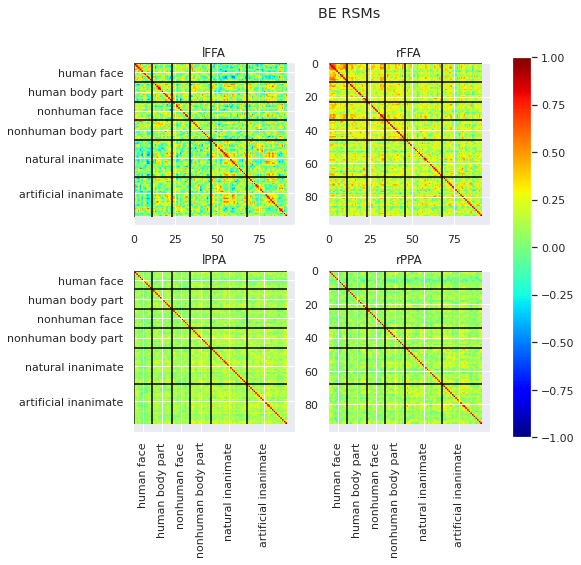

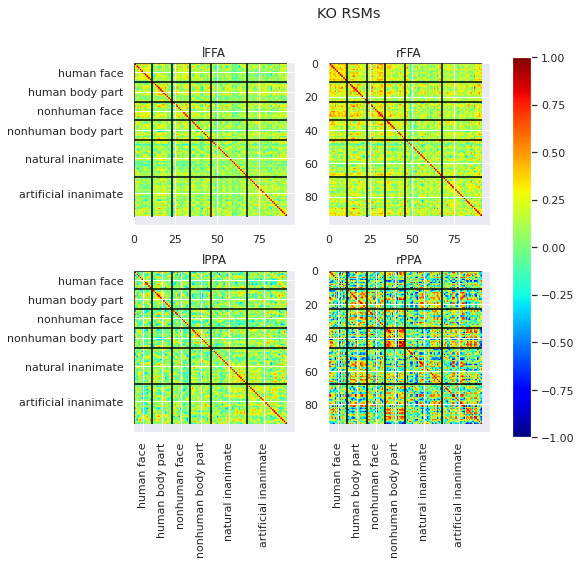

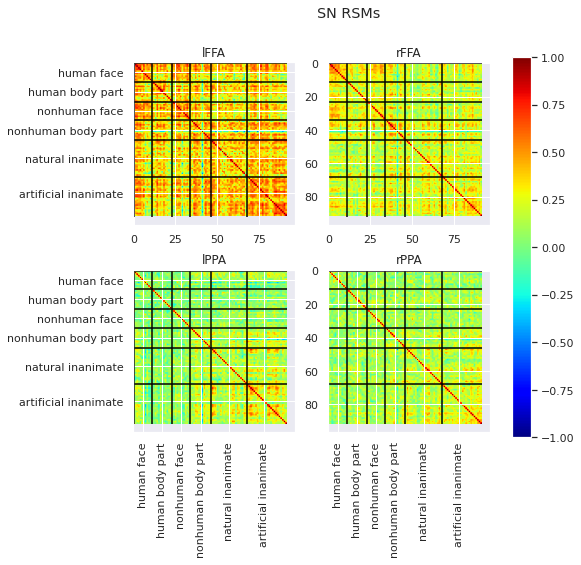

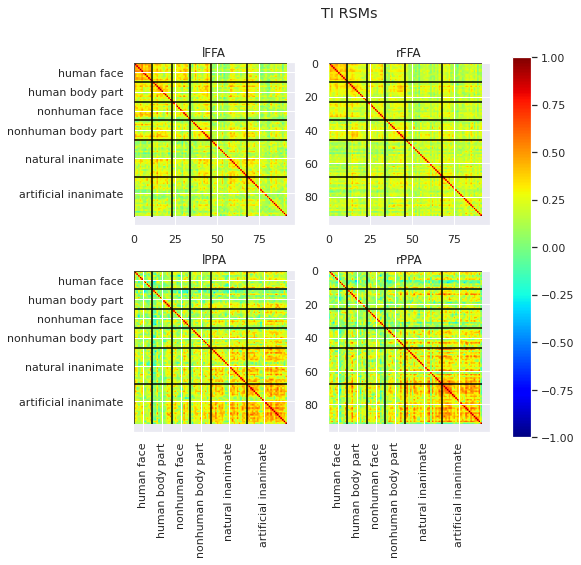

In [239]:
# generate RSMs
show_rsms(BE_rsms, 'BE RSMs', 'be_rsms.png')
show_rsms(KO_rsms, 'KO RSMs', 'ko_rsms.png')
show_rsms(SN_rsms, 'SN RSMs', 'sn_rsms.png')
show_rsms(TI_rsms, 'TI RSMs', 'ti_rsms.png')

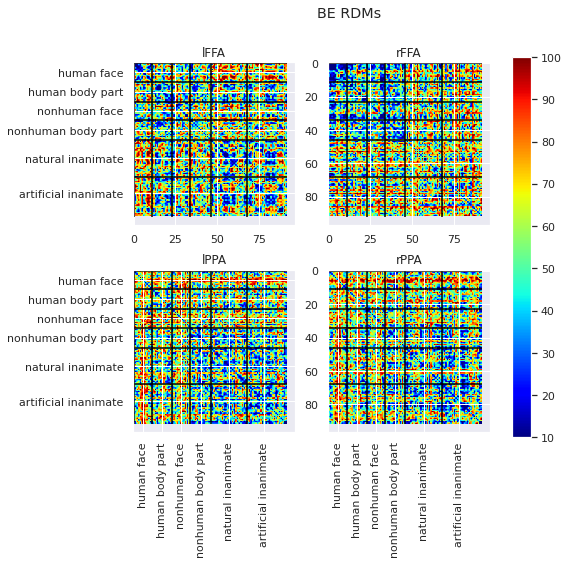

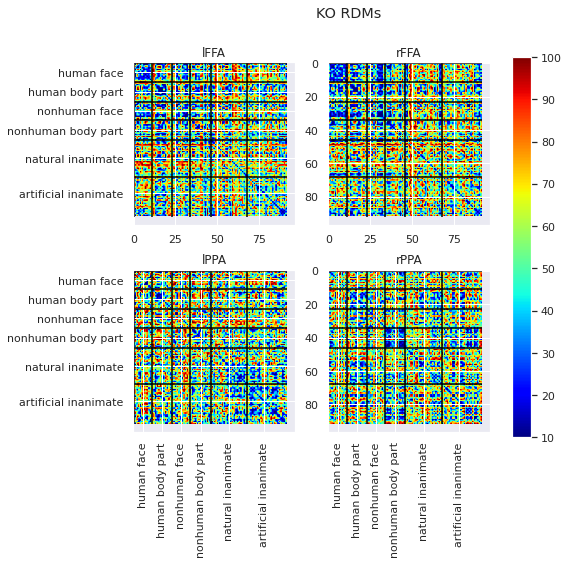

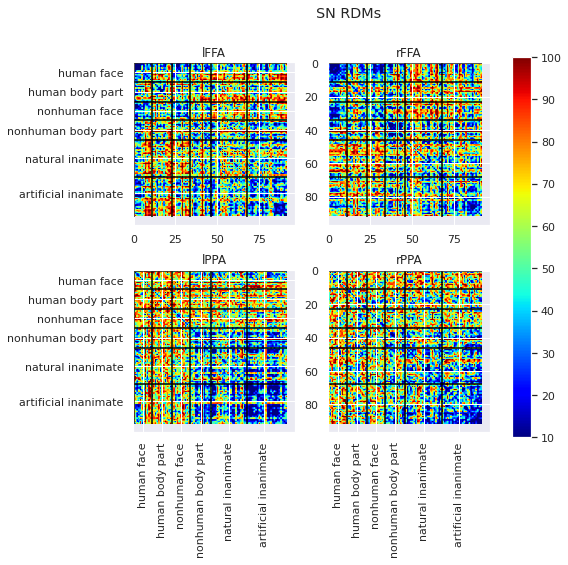

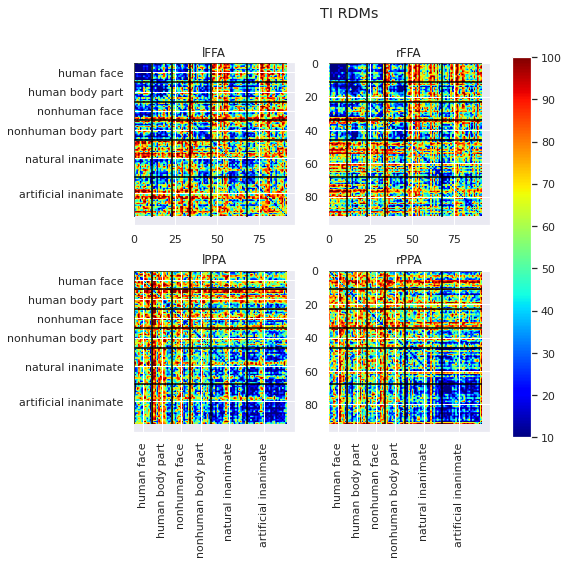

In [237]:
# generate RDMs
show_rdms(BE_rdms, 'BE RDMs', 'be_rdms.png')
show_rdms(KO_rdms, 'KO RDMs', 'ko_rdms.png')
show_rdms(SN_rdms, 'SN RDMs', 'sn_rdms.png')
show_rdms(TI_rdms, 'TI RDMs', 'ti_rdms.png')

## 1.4: Saving matrices

In [178]:
all_rsms = np.asarray([BE_rsms, KO_rsms, SN_rsms, TI_rsms])
all_rdms = np.asarray([BE_rdms, KO_rdms, SN_rdms, TI_rdms])

In [181]:
np.save('human_data.npy', np.asarray([all_rsms, all_rdms]))

In [182]:
np.save('images.npy', ordered_images)

# 1.5 Comparing RDMS

Utilizing Spearman correlation as the similarity metric

In [219]:
from scipy.stats import spearmanr
n_subj = 4

## 1.5.1: Same ROI, different individuals

In [223]:
subj_inits = ['BE', 'KO', 'SN', 'TI']

In [234]:
print("Similarity between individuals for the same ROI:")
# i = ROI
for i in range(n_rois):
  # j = individual 1
  for j in range(n_subj):
    # k = individual 2
    for k in range(n_subj):
      if j < k:
        rdm1 = all_rsms[j, i]
        rdm2 = all_rsms[k, i]
        res = spearmanr(rdm1, rdm2, axis=None)
        print(f'{roi_names[i]}: {subj_inits[j]}, {subj_inits[k]}: {res.statistic: .3f}')

Similarity between individuals for the same ROI:
lFFA: BE, KO:  0.069
lFFA: BE, SN:  0.046
lFFA: BE, TI:  0.073
lFFA: KO, SN:  0.190
lFFA: KO, TI:  0.098
lFFA: SN, TI:  0.159
rFFA: BE, KO:  0.128
rFFA: BE, SN:  0.133
rFFA: BE, TI:  0.105
rFFA: KO, SN:  0.127
rFFA: KO, TI:  0.207
rFFA: SN, TI:  0.123
lPPA: BE, KO:  0.079
lPPA: BE, SN:  0.099
lPPA: BE, TI:  0.111
lPPA: KO, SN:  0.100
lPPA: KO, TI:  0.066
lPPA: SN, TI:  0.267
rPPA: BE, KO:  0.046
rPPA: BE, SN:  0.042
rPPA: BE, TI:  0.190
rPPA: KO, SN:  0.060
rPPA: KO, TI:  0.067
rPPA: SN, TI:  0.148


In [235]:
print("Similarity within individuals for different ROIs:")
# i = individual
for i in range(n_subj):
  # j = ROI 1
  for j in range(n_rois):
    # k = ROI 2
    for k in range(n_rois):
      if j < k:
        rdm1 = all_rsms[i, j]
        rdm2 = all_rsms[i, k]
        res = spearmanr(rdm1, rdm2, axis=None)
        print(f'{subj_inits[i]}: {roi_names[j]}, {roi_names[k]}: {res.statistic: .3f}')

Similarity within individuals for different ROIs:
BE: lFFA, rFFA:  0.093
BE: lFFA, lPPA:  0.179
BE: lFFA, rPPA:  0.133
BE: rFFA, lPPA:  0.209
BE: rFFA, rPPA:  0.178
BE: lPPA, rPPA:  0.419
KO: lFFA, rFFA:  0.641
KO: lFFA, lPPA:  0.314
KO: lFFA, rPPA:  0.142
KO: rFFA, lPPA:  0.312
KO: rFFA, rPPA:  0.158
KO: lPPA, rPPA:  0.248
SN: lFFA, rFFA:  0.256
SN: lFFA, lPPA:  0.210
SN: lFFA, rPPA:  0.108
SN: rFFA, lPPA:  0.263
SN: rFFA, rPPA:  0.223
SN: lPPA, rPPA:  0.276
TI: lFFA, rFFA:  0.486
TI: lFFA, lPPA:  0.166
TI: lFFA, rPPA:  0.189
TI: rFFA, lPPA:  0.208
TI: rFFA, rPPA:  0.287
TI: lPPA, rPPA:  0.455


# Stuff from Tutorial

Similarity metric: Pearson correlation

Compute the similarity between each of the neural responses. We can compute this for each ROI. We build a 92x92 matrix since the last four images don't have labels.

Text(0, 0.5, 'stimuli id')

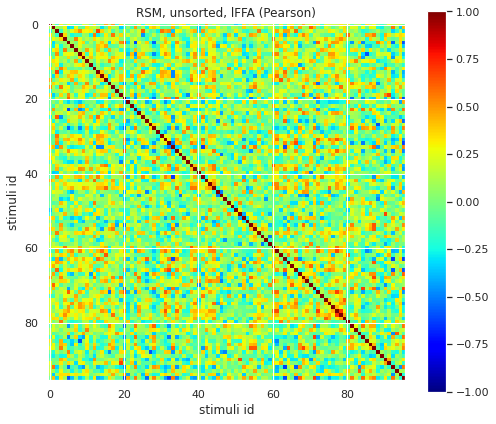

In [ ]:
# Choose your ROI here!
roi_id = 0 

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    np.corrcoef(roi_data[roi_id]), 
    cmap='jet', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s (Pearson)' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

In [ ]:
roi_data[roi_id].shape

(96, 34)

Text(0, 0.5, 'stimuli id')

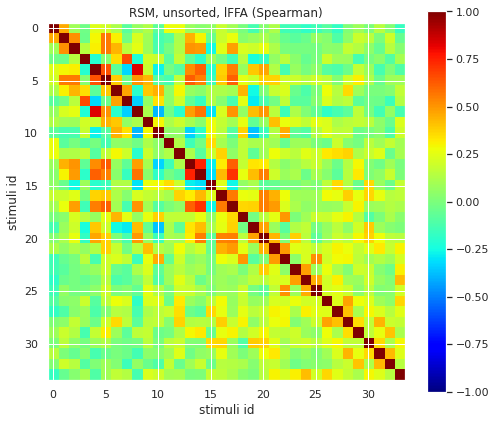

In [ ]:
# RSM with spearman correlation instead
from scipy.stats import spearmanr

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

rank_srm, _ = spearmanr(roi_data[roi_id])

plt.imshow(
    rank_srm,
    cmap='jet',
    vmin=-1,
    vmax=1
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s (Spearman)' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

In [ ]:
rank_srm.shape

(34, 34)

`rank_srm` is 34 x 34 because 34 is the number of voxels. Need to explore the differences between Pearson and Spearman more